In [ ]:
!pip install pycaret --quiet --upgrade
!pip install dabl --quiet --upgrade
!pip install shap --quiet --upgrade
!pip install sdv  --quiet --upgrade
!pip install sdv[ctgan] --quiet --upgrade
!pip install baytune --quiet --upgrade
!pip install optuna --quiet --upgrade

# **Will they stay or will they go? Predicting employee attrition and improving models with synthetic data**
---

## **Why this was done**
1. Learn about synthetic data generation and see if it can improve a model
2. Work with PyCaret on a classification problem
3. Provide interpretation of the model(s) used so it can be known WHY a model is predicting A or B
4. Work on an HR related problem

## **The data**
HR data isn't easy to find given the nature of the data. However IBM has created [fictious data](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) around whether an employee left after 6 months which can be used. The features for each employee are...

* ` Age `
* ` Attrition `
* ` BusinessTravel `
* ` DailyRate `
* ` Department `
* ` DistanceFromHome `
* ` Education `
* ` EducationField `
* ` EmployeeCount `
* ` EmployeeNumber `
* ` EnvironmentSatisfaction `
* ` Gender `
* ` HourlyRate `
* ` JobInvolvement `
* ` JobLevel `
* ` JobRole `
* ` JobSatisfaction `
* ` MaritalStatus `
* ` MonthlyIncome `
* ` MonthlyRate `
* ` NumCompaniesWorked `
* ` Over18 `
* ` OverTime `
* ` PercentSalaryHike `
* ` PerformanceRating `
* ` RelationshipSatisfaction `
* ` StandardHours `
* ` StockOptionLevel `
* ` TotalWorkingYears `
* ` TrainingTimesLastYear `
* ` WorkLifeBalance `
* ` YearsAtCompany `
* ` YearsInCurrentRole `
* ` YearsSinceLastPromotion `
* ` YearsWithCurrManager `

# **The main problems**
When looking at employee data you may not have millions of employees. When  building a model often you need a lot of data. We have a potential problem of **not having enough data**.

Alongside not having a lot of data to model with, the majority of people will most likely not leave if the company is good. So in the data you'll have say 10% of employees left in 6 months and 90% stayed. This is an **imbalanced classification problem**

The solution to the problem - **generate synthetic data**

Why?
1. It captures the characteristics of the original data
2. If the small volume class is the only one generated then the imbalanced problem and data volume disappears
3. You train with the synthetic data but remove it when testing you still get reliable evaluation metrics

# **Libraries**

In [2]:
from pycaret.classification import * # Preprocessing, modelling, interpretation, deployment...
import pandas as pd # Basic data manipulation
import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps

# **Importing data**

In [5]:
# Read and output some of the data
hr_data = pd.read_csv("HR Employee Attrition.csv")
hr_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# **Visualising**
As mentioned the main problem with this dataset is a large class imbalance for the target feature `Attrition`. I will model the data with the imbalance to see how it performs but there will be a way to improve it, synthetic data generation.

The other features look somewhat normal except for `StandardHours` and `EmployeeCount` which have zero variance hence will be ignored.

Target looks like classification


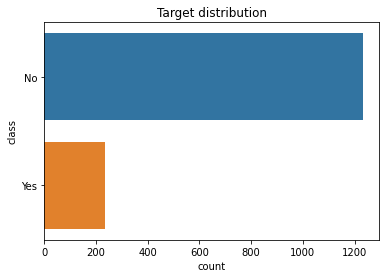

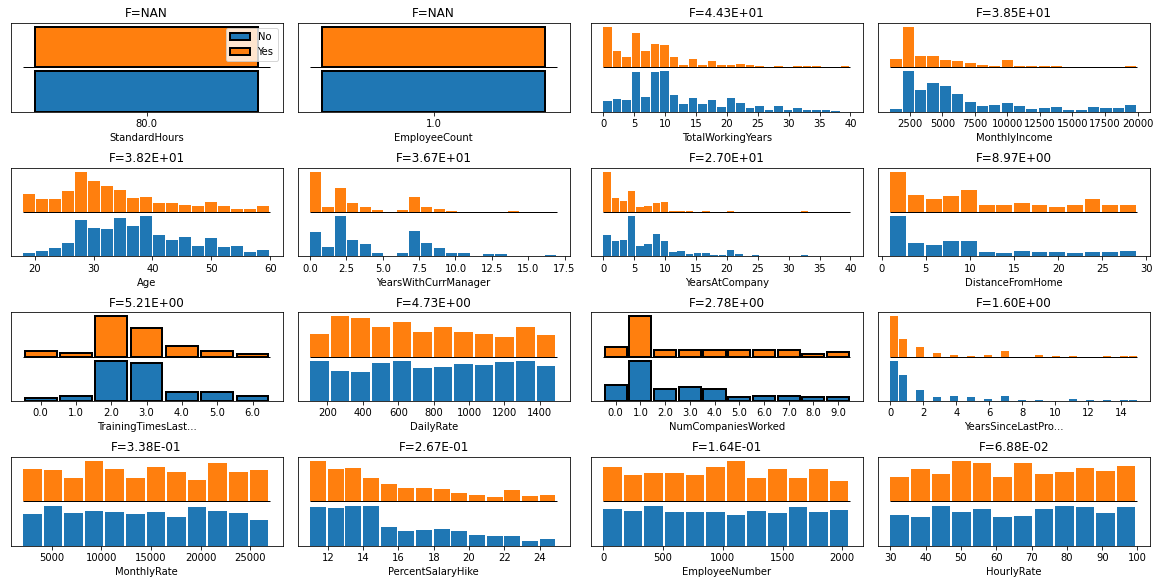

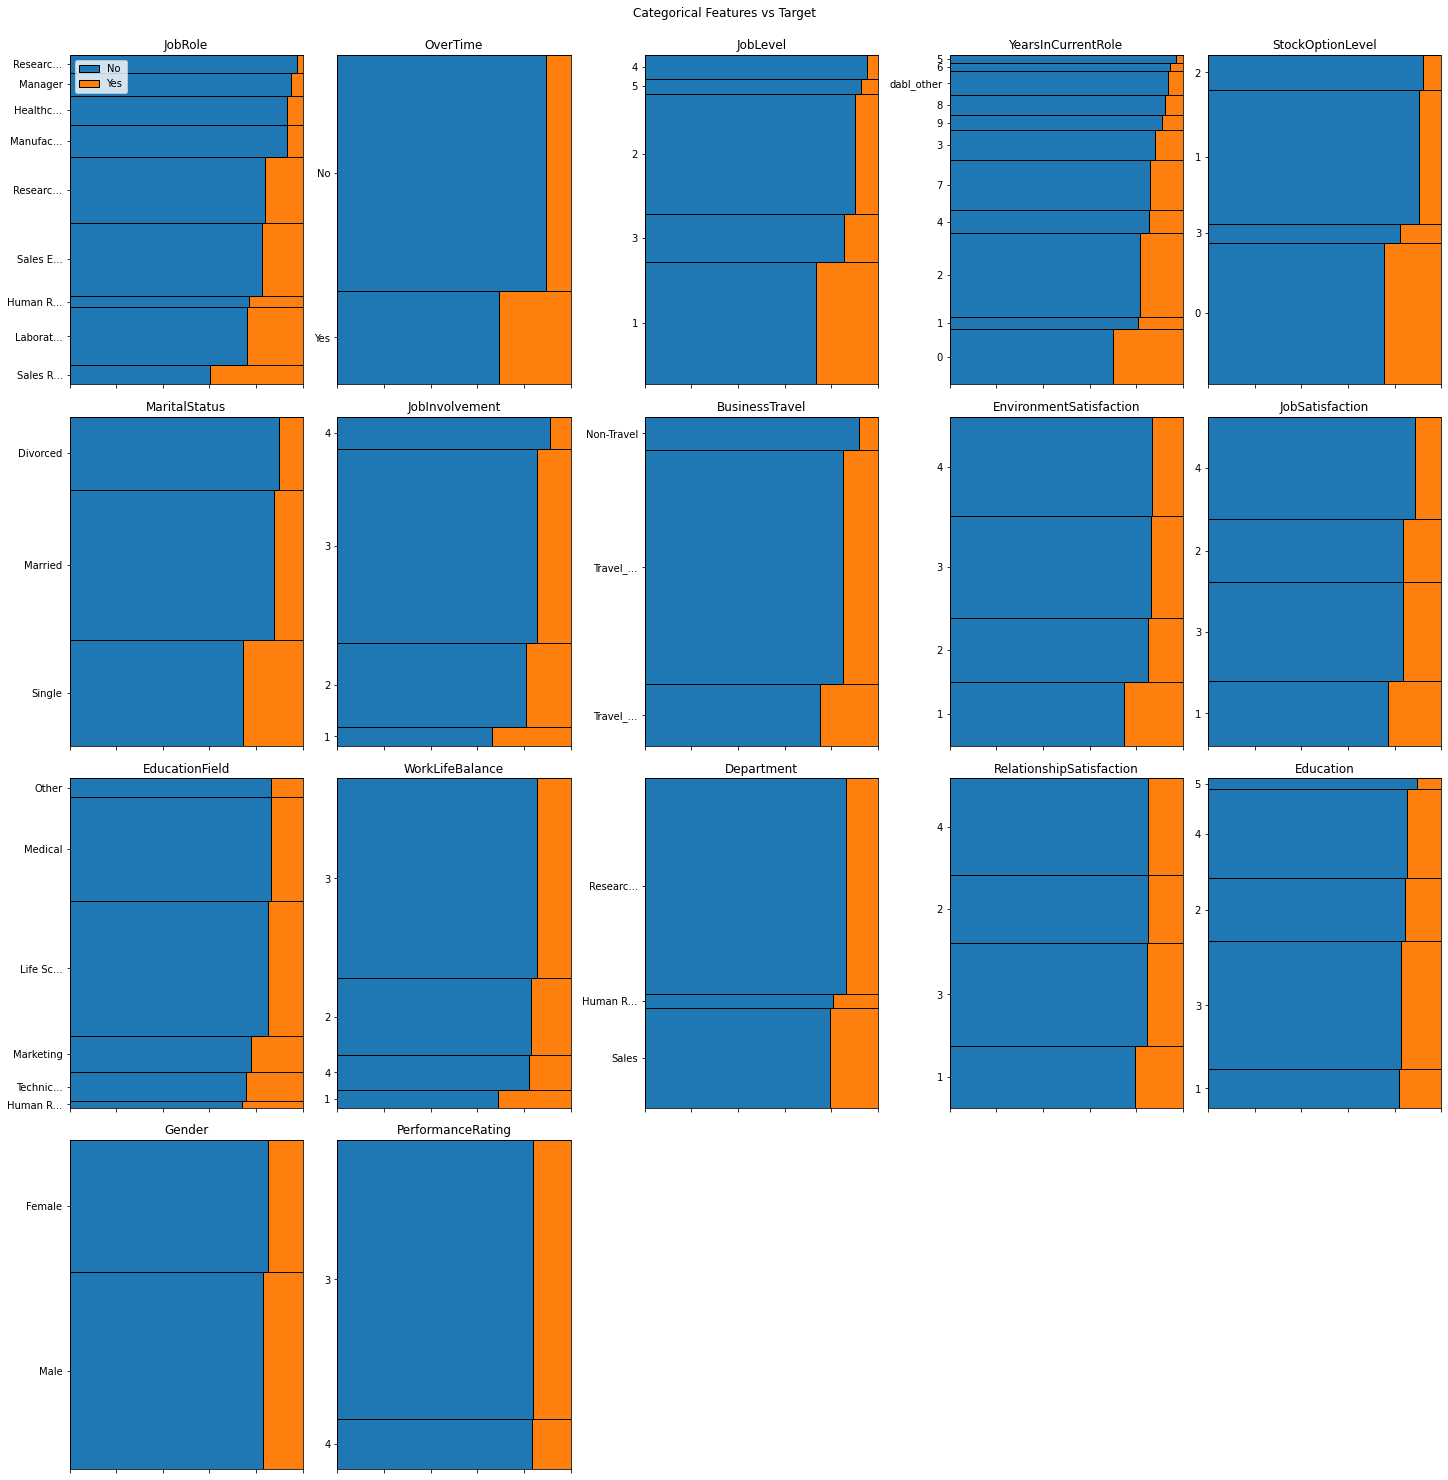

In [ ]:
# Plot summaries of continuous + categorical features
## Type hints are used to force types on certain features
types = {"DistanceFromHome" : "continuous", "EmployeeCount" : "continuous",
         "HourlyRate" : "continuous", "MonthlyRate" : "continuous", 
         "NumCompaniesWorked" : "continuous", "PercentSalaryHike" : "continuous",
         "StandardHours" : "continuous", "TotalWorkingYears" : "continuous", 
         "YearsAtCompany" : "continuous", "YearsSinceLastPromotion" : "continuous",
         "YearsWithCurrManager" : "continuous", "TrainingTimesLastYear" : "continuous",
         "Age" : "continuous", "DailyRate" : "continuous", "MonthlyIncome" : "continuous"}

db.plot(hr_data, y = "Attrition", type_hints = types, plot_pairwise = False)

# **First modelling w/original data**
I'll use `Pycaret` to model the data given it's speed. It can handle a lot of the preprocessing, modelling, evaluation and interpretation. Given the dataset is ~1.5k rows the processing isn't too intensive but if it increased in size thankfully Pycaret has GPU functionality.

Ordinal features need to have their levels known and order which can quickly be done.

In [6]:
ord_levels = ['StockOptionLevel', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 
              'Education', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']

for feat in ord_levels:
  print(feat, hr_data[feat].unique())

StockOptionLevel [0 1 3 2]
EnvironmentSatisfaction [2 3 4 1]
JobInvolvement [3 2 4 1]
JobSatisfaction [4 2 3 1]
Education [2 1 4 3 5]
PerformanceRating [3 4]
RelationshipSatisfaction [1 4 2 3]
WorkLifeBalance [1 3 2 4]


A fairly simply ordering per feature. Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [7]:
# Initialise appropriate features for pycaret

# Target feature
target = "Attrition"

# Continuous features
cont_feats = ["DistanceFromHome", "HourlyRate",  "DailyRate", "MonthlyIncome",
              "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike",
              "TotalWorkingYears", "YearsAtCompany", "YearsInCurrentRole",
              "YearsWithCurrManager", "TrainingTimesLastYear", "YearsSinceLastPromotion"]

# Ordinal features
ord_feats = {"StockOptionLevel" : ["0", "1", "2", "3"],
             "EnvironmentSatisfaction" : ["1", "2", "3", "4"],
             "JobInvolvement" : ["1", "2", "3", "4"],
             "JobSatisfaction" : ["1", "2", "3", "4"],
             "Education" : ["1", "2", "3", "4", "5"],
             "PerformanceRating" : ["3", "4"],
             "RelationshipSatisfaction" : ["1", "2", "3", "4"],
             "WorkLifeBalance" : ["1", "2", "3", "4"]}

# Categorical geatures
cat_feats = ["BusinessTravel", "Department", "EducationField", 
             "JobRole", "Gender", "JobLevel", "JobRole", 
             "MaritalStatus", "OverTime", "WorkLifeBalance"]

# Features to ignore
ignore = ["EmployeeNumber", "StandardHours", "EmployeeCount", "Over18"]

Now with the features initalised can be fed into pycaret's `setup` function.
* Feed in data + features
* Normalize continuous features + use `minimax` as the normalization method
* Use stratified k folding on the data
* Cross validation
* Remove features with low variance

There a lot on offer but not everything is used here.

In [ ]:
# Run pycaret setup
setup(hr_data, 
      target = target,
      train_size = 0.7, 
      fold_strategy = "stratifiedkfold",
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "zscore",
      data_split_stratify = True,
      ignore_low_variance = True,
      silent = True)

,Description,Value
0,session_id,2633
1,Target,Attrition
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(1470, 35)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,16
8,Ordinal Features,True
9,High Cardinality Features,False


(False,
 'lightgbm',
 True,
 10,
 False,
 {'ada': <pycaret.containers.models.classification.AdaBoostClassifierContainer at 0x7f663dd75b38>,
  'catboost': <pycaret.containers.models.classification.CatBoostClassifierContainer at 0x7f663dd6f898>,
  'dt': <pycaret.containers.models.classification.DecisionTreeClassifierContainer at 0x7f672e770c88>,
  'et': <pycaret.containers.models.classification.ExtraTreesClassifierContainer at 0x7f672cff85c0>,
  'gbc': <pycaret.containers.models.classification.GradientBoostingClassifierContainer at 0x7f67363c7e80>,
  'gpc': <pycaret.containers.models.classification.GaussianProcessClassifierContainer at 0x7f67391ebeb8>,
  'knn': <pycaret.containers.models.classification.KNeighborsClassifierContainer at 0x7f663dd027f0>,
  'lda': <pycaret.containers.models.classification.LinearDiscriminantAnalysisContainer at 0x7f67363e1cf8>,
  'lightgbm': <pycaret.containers.models.classification.LGBMClassifierContainer at 0x7f663dd6f8d0>,
  'lr': <pycaret.containers.model

Now it's "setup", I like to use `compare_models` to get a rough idea as to which model(s) might be best for this particular use case. The particular metrics I'm looking at are `AUC`, `Precision` and `Recall`. `Recall` is most important as we want to make sure we are correctly identifying the **true negatives** i.e. those that might leave in 6 months.

In [ ]:
compare_models(sort = "AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8794,0.8418,0.4397,0.7017,0.5292,0.4667,0.4884,0.278
lda,Linear Discriminant Analysis,0.8726,0.8362,0.4342,0.6601,0.5158,0.4478,0.4646,0.023
catboost,CatBoost Classifier,0.8697,0.8101,0.2474,0.8089,0.3691,0.3222,0.3946,2.163
gbc,Gradient Boosting Classifier,0.8639,0.8080,0.3257,0.6452,0.4223,0.3584,0.3884,0.248
lightgbm,Light Gradient Boosting Machine,0.8590,0.8041,0.2952,0.6637,0.3916,0.3282,0.3694,0.101
rf,Random Forest Classifier,0.8561,0.8028,0.1515,0.8190,0.2458,0.2075,0.3009,0.509
ada,Ada Boost Classifier,0.8667,0.8018,0.3971,0.6395,0.4756,0.4075,0.4285,0.130
et,Extra Trees Classifier,0.8590,0.7957,0.2110,0.7279,0.3195,0.2682,0.3352,0.456
xgboost,Extreme Gradient Boosting,0.8658,0.7887,0.3482,0.6798,0.4448,0.3797,0.4131,5.887
nb,Naive Bayes,0.6285,0.7559,0.7658,0.2743,0.4024,0.2157,0.2737,0.017


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2633, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

So `Logistic Regression` is looking promising so I'll build a model on this. As shown below each fold's metrics are shown and the average.

In [ ]:
lr = create_model("lr")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8447,0.7450,0.2500,0.5000,0.3333,0.2563,0.2761
1,0.8932,0.9109,0.3750,0.8571,0.5217,0.4718,0.5232
2,0.9029,0.9063,0.6471,0.7333,0.6875,0.6303,0.6320
3,0.8738,0.8611,0.4706,0.6667,0.5517,0.4808,0.4907
4,0.8641,0.8112,0.4706,0.6154,0.5333,0.4554,0.4611
5,0.8835,0.7606,0.4118,0.7778,0.5385,0.4789,0.5107
6,0.8447,0.7969,0.1765,0.6000,0.2727,0.2137,0.2647
7,0.8932,0.9207,0.4706,0.8000,0.5926,0.5358,0.5609
8,0.9020,0.8590,0.5000,0.8000,0.6154,0.5626,0.5830
9,0.8922,0.8467,0.6250,0.6667,0.6452,0.5817,0.5821


Some hyperparameter tuning may help improve the model a bit so I'll use `tune_model` and focus on `AUC`. I'm using the `optuna` library and searching using `tpe` searching algorithm.

Overall there doesn't seem like much improvement.

In [ ]:
tune_model(lr, optimize = "AUC", n_iter = 50, search_library = "optuna", search_algorithm = "tpe")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8447,0.7493,0.2500,0.5000,0.3333,0.2563,0.2761
1,0.8835,0.9095,0.3750,0.7500,0.5000,0.4422,0.4764
2,0.9029,0.9077,0.6471,0.7333,0.6875,0.6303,0.6320
3,0.8738,0.8618,0.4706,0.6667,0.5517,0.4808,0.4907
4,0.8544,0.8085,0.4706,0.5714,0.5161,0.4314,0.4342
5,0.8738,0.7620,0.4118,0.7000,0.5185,0.4515,0.4725
6,0.8447,0.7975,0.1765,0.6000,0.2727,0.2137,0.2647
7,0.8835,0.9207,0.4706,0.7273,0.5714,0.5076,0.5237
8,0.9020,0.8626,0.5000,0.8000,0.6154,0.5626,0.5830
9,0.8922,0.8445,0.6250,0.6667,0.6452,0.5817,0.5821


LogisticRegression(C=1.7415032078134458, class_weight={}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2633, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# **How to solve this problem**
So the model being used isn't the best. Hyperparameter tuning saw a small improvement but very minimal.

The area that I don't see being explored to improve models is **generating synthetic data**. There's talk about getting more data but what if you can't? **GENERATE IT**.

The problem is making sure the data generated shares similar characteristics as the original data. An evaluation metric can be used for this.

# **Generating synthetic data**
There's a useful library `sdev` [Synthetic Data Generation](https://github.com/sdv-dev/SDV) to generate synthetic tabular data. I've played around with it specifically the `CopulaGAN` model.

The general idea is to provide a `primary key` and to then run the model for so many `epochs`. There are hyperparameters to tune
* `epochs`
* `batch_size`
* `embedding_dim`
* `gen_dim`
* `dis_dim`
* `l2scale` (omitted in this experiment)



Rather than running a CopulaGAN without hyperparameters or guessing hyperparameters I've leveraged `BTB` which is an optimisation library. To start I'll initialise the `GCPTuner` which is used to declare the hyperparameters to tune. Then the hyperparameters can be called using `propose` from BTB.

In [ ]:
tuner = GCPTuner(Tunable({
          'epochs': hp.IntHyperParam(min = 80, max = 400),
          'batch_size' : hp.IntHyperParam(min = 1, max = 100),
          'embedding_dim' : hp.IntHyperParam(min = 1, max = 100),
          'gen' : hp.IntHyperParam(min = 1, max = 1000),
          'dim_gen' : hp.IntHyperParam(min = 1, max = 1000)
        }))

With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [ ]:
best_score = 0 # Keep track of best score
tracker = 0 # Keep track of how many loops have completed

real = hr_data[hr_data["Attrition"] == "Yes"] # Filter to only those employees that left

## TRAINING LOOP START ##
for _ in range(75):

  # Increment the tracker
  tracker += 1

  # Every 5 loops output the tracker
  if tracker % 5 == 0:
    print(tracker)

  # Get the hyperparameters for this loop
  proposal = tuner.propose(1)
  
  # Create the CopulaGAN
  # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
  model = CopulaGAN(primary_key = "EmployeeNumber", 
                    embedding_dim = proposal['embedding_dim'],
                    gen_dim = (proposal['gen'], proposal['gen']),
                    dis_dim = (proposal['dim_gen'], proposal['dim_gen']),
                    batch_size = proposal['batch_size'] * 10,
                    epochs = proposal['epochs'])
  
  # Fit the CopulaGAN
  model.fit(real)
  
  # Create 600 rows of data
  synth_data = model.sample(600, max_retries = 300)
  
  # Evaluate the synthetic data against the real data
  score = evaluate(synthetic_data = synth_data, real_data = real)

  # If the new hyperparameters beat the best ones, store them along with the score
  if score > best_score:
    best_params = proposal
    best_score = score

  # Record the hyperparameters and score      
  tuner.record(proposal, score)

## TRAINING LOOP END ##


print('Best score obtained: ', best_score)
print('Best parameters: ', best_params)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
Best score obtained:  0.8127129012858366
Best parameters:  {'epochs': 208, 'batch_size': 42, 'embedding_dim': 10, 'gen': 54, 'dim_gen': 788}


In [ ]:
model.save('best_copula.pkl')

In [ ]:
synth_data.to_csv("synth_data.csv", index = False)

So after 75 loops the overall score is 0.8 (this score is between 0 and 1) for 600 synthetic examples of Attrition = "Yes" so it's not too bad.

```
Best score obtained:  0.8127129012858366
Best parameters:  {'epochs': 208, 'batch_size': 42, 'embedding_dim': 10, 'gen': 54, 'dim_gen': 788}
```
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [8]:
# Load synth data in
synth_data = pd.read_csv("synth_data.csv")

# Split real data into training + test set
train, test, target_train, target_test = train_test_split(hr_data.drop("Attrition", axis = 1), hr_data["Attrition"], test_size = 0.4, random_state = 42)

# Add Attrition column back into training + test set
train["Attrition"] = target_train
test["Attrition"] = target_test

# Add the 600 synthetic rows of data to training data + remove dataset column
input = pd.concat([train, synth_data])

In [9]:
for feat in list(ord_feats.keys()):
  print(feat, input[feat].unique())

StockOptionLevel [0 1 2 3 4 5]
EnvironmentSatisfaction [2 3 1 4 5]
JobInvolvement [3 2 4 1]
JobSatisfaction [4 2 3 1 0 5]
Education [4 2 3 1 5]
PerformanceRating [3 4 5]
RelationshipSatisfaction [4 2 1 3 0 5]
WorkLifeBalance [2 3 4 1]


In [10]:
ord_feats = {"StockOptionLevel" : ["0", "1", "2", "3", "4", "5"],
             "EnvironmentSatisfaction" : ["1", "2", "3", "4", "5"],
             "JobInvolvement" : ["1", "2", "3", "4"],
             "JobSatisfaction" : ["0", "1", "2", "3", "4", "5"],
             "Education" : ["1", "2", "3", "4", "5"],
             "PerformanceRating" : ["3", "4", "5"],
             "RelationshipSatisfaction" : ["0", "1", "2", "3", "4", "5"],
             "WorkLifeBalance" : ["1", "2", "3", "4"]}

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of synthetic and real data in the training set but only real in the test data.

In [11]:
# Run pycaret setup
setup(input, 
      target = target, 
      test_data = test,
      fold_strategy = "stratifiedkfold",
      train_size = 0.7, 
      transformation = True,
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "zscore",
      data_split_stratify = True,
      ignore_low_variance = True,
      silent = True)

,Description,Value
0,session_id,8112
1,Target,Attrition
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(1482, 35)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,16
8,Ordinal Features,True
9,High Cardinality Features,False


({'acc': <pycaret.containers.metrics.classification.AccuracyMetricContainer at 0x7fe4497afa58>,
  'auc': <pycaret.containers.metrics.classification.ROCAUCMetricContainer at 0x7fe4497afba8>,
  'f1': <pycaret.containers.metrics.classification.F1MetricContainer at 0x7fe449745f98>,
  'kappa': <pycaret.containers.metrics.classification.KappaMetricContainer at 0x7fe44972f080>,
  'mcc': <pycaret.containers.metrics.classification.MCCMetricContainer at 0x7fe44972f0f0>,
  'precision': <pycaret.containers.metrics.classification.PrecisionMetricContainer at 0x7fe4497afb70>,
  'recall': <pycaret.containers.metrics.classification.RecallMetricContainer at 0x7fe4497afac8>},
 '82f5',
 True,
 False,
 False,
            Age  DailyRate  ...  MaritalStatus_Single  OverTime_No
 1041 -0.664969  -0.124357  ...                   1.0          1.0
 184   1.532729   0.389744  ...                   0.0          1.0
 1222 -1.112132  -1.413396  ...                   0.0          1.0
 67    0.921007   1.035870  ...   

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [ ]:
compare_models(sort = "AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8951,0.9624,0.8473,0.9416,0.8618,0.7920,0.8132,2.493
gbc,Gradient Boosting Classifier,0.8903,0.9560,0.8472,0.9290,0.8619,0.7823,0.8004,0.349
rf,Random Forest Classifier,0.8762,0.9523,0.8473,0.9030,0.8496,0.7538,0.7720,0.554
lightgbm,Light Gradient Boosting Machine,0.8815,0.9500,0.8406,0.9224,0.8559,0.7645,0.7834,0.113
et,Extra Trees Classifier,0.8721,0.9447,0.8445,0.8964,0.8536,0.7453,0.7592,0.508
xgboost,Extreme Gradient Boosting,0.8687,0.9436,0.8367,0.8960,0.8474,0.7387,0.7532,1.454
ada,Ada Boost Classifier,0.8552,0.9354,0.8366,0.8704,0.8402,0.7113,0.7227,0.158
lda,Linear Discriminant Analysis,0.8206,0.9088,0.8072,0.8403,0.8172,0.6414,0.6490,0.027
lr,Logistic Regression,0.8226,0.9085,0.8164,0.8353,0.8206,0.6454,0.6517,0.065
knn,K Neighbors Classifier,0.7540,0.8550,0.5509,0.9312,0.6679,0.5129,0.5590,0.121


In [12]:
gbc = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6174,0.7727,0.3026,0.8519,0.4466,0.2446,0.3216
1,0.6779,0.8646,0.3816,0.9667,0.5472,0.3634,0.4586
2,0.9527,0.9958,0.9733,0.9359,0.9542,0.9053,0.9061
3,0.9392,0.9905,0.9733,0.9125,0.9419,0.8782,0.8803
4,0.9797,0.9974,0.9867,0.9737,0.9801,0.9594,0.9595
5,0.9459,0.9898,0.9600,0.9351,0.9474,0.8918,0.8922
6,0.9122,0.9695,0.9605,0.8795,0.9182,0.8237,0.8275
7,0.9459,0.9881,0.9605,0.9359,0.9481,0.8917,0.8921
8,0.9730,0.9973,0.9868,0.9615,0.9740,0.9459,0.9462
9,0.9595,0.9942,0.9868,0.9375,0.9615,0.9187,0.9201


# **Finalising the model**
Now with the model trained and evaluated it needs to be **finalised**. This encorporates the test data into the model that will be used on unseen data.

In [13]:
 final_gbc = finalize_model(gbc)

In [14]:
save_model(final_gbc, "final_gbc")

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['BusinessTravel',
                                                             'Department',
                                                             'EducationField',
                                                             'JobRole', 'Gender',
                                                             'JobLevel',
                                                             'JobRole',
                                                             'MaritalStatus',
                                                             'OverTime',
                                                             'WorkLifeBalance'],
                                       display_types=False,
                                       features_todrop=['EmployeeNumber',
                                                        'StandardHours',
                                                  

# **Saving and exporting ready for app build**
To use the model in a `streamlit` app certain things need to be exported
* The model
* Preprocessed data
* Preparation steps (`prep pipe`)

In [16]:
save_model(gbc, "gbc_model") # Model
get_config("X").to_csv("preprocssed_data.csv", index = False) # Preprocessed data
prep = get_config("prep_pipe") # Preparation steps
joblib.dump(prep, 'prep_pipe.pkl', compress = 1) # Save preparation steps

Transformation Pipeline and Model Succesfully Saved


['prep_pipe.pkl']

# **Interpretating model performance and predictions**
Using `plot_model` the model's performance can be further asessed. One example is feature importance i.e. which features have a high importance when it comes to predictions. In this case

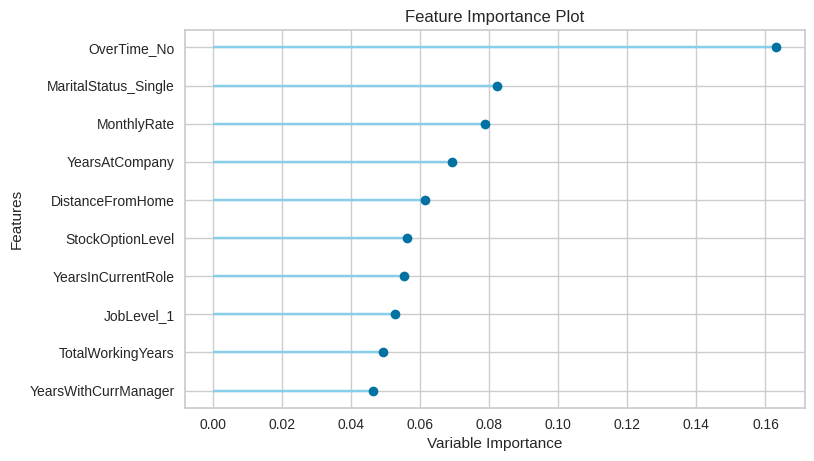

In [ ]:
plot_model(gbc, "feature")